## Generate synthetic corpus

In [48]:
import numpy as np
import pandas as pd

# =============================================================================
# Generate User-Item Matrix
# =============================================================================
n_u = 1000  # user number
n_v = 100   # item number
n_r = 5 # average number of ratings per user
n_factors = 5  # number of latent factors
V = 100 # vocabulary size
beta = 0.01 # smoothing parameter of topic-word distribution
kappa = 1.0 # transformation parameter
n_w = 30 # avg length of review
np.random.seed(0)

bias_user = np.zeros(n_u)
U_matrix = np.zeros((n_u,n_factors))
# generate bias and latent fators for users
for i in range(n_u):
    bias_user[i] = np.random.normal()
    mean = np.zeros(n_factors)
    cov = np.eye(n_factors)
    U_matrix[i] = np.abs(np.random.multivariate_normal(mean, cov))

bias_item = np.zeros(n_v)
V_matrix = np.zeros((n_v,n_factors))
# generate bias and latent factors for items
for j in range(n_v):
    bias_item[j] = np.random.normal()
    mean = np.zeros(n_factors)
    cov = np.eye(n_factors)
    V_matrix[j] = np.random.multivariate_normal(mean, cov)

# generate word distributions for topics (latent factors)
phi = np.zeros((n_factors*2,V))
for k in range(n_factors*2):
    phi[k] = np.random.dirichlet([beta]*V)


data = []
data_theta = []
# generate ratings and reviews given users and items
for i in range(n_u):
    n_ur = np.random.poisson(n_r)
    select_items = np.random.choice(np.arange(n_v), n_ur)    
    for j in select_items:
        residual = np.random.normal(scale=1.0)
        score_ij = bias_user[i] + bias_item[j] + U_matrix[i].dot(V_matrix[j]) + residual
        theta_pos = np.exp(kappa * U_matrix[i] * V_matrix[j])
        theta_neg = np.exp(-1 * kappa * U_matrix[i] * V_matrix[j])
        theta = np.concatenate((theta_pos,theta_neg))
        theta /= np.sum(theta)
        doc = []
        for n in range(n_w):
            k = np.random.choice(np.arange(n_factors*2),p=theta)
            w = np.random.choice(np.arange(V),p=phi[k])
            doc.append(w)
        data.append([i,j,score_ij,doc])
        data_theta.append(theta)
df = pd.DataFrame(data,columns = ['user','item','rating','review'])
vocab = dict(enumerate([str(w) for w in list(range(V))]))
#df.to_csv('rating_matrix.csv')

# validation set
val_data = []
errors = 0
for i in range(n_u):
    j = np.random.choice(np.arange(n_v))
    residual = np.random.normal(scale=1.0)
    errors += residual**2
    score_ij = bias_user[i] + bias_item[j] + U_matrix[i].dot(V_matrix[j]) + residual
    val_data.append([i, j, score_ij])
val_df = pd.DataFrame(val_data, columns=['user', 'item', 'rating'])

print(val_df['rating'].var())
print(df['rating'].mean())

7.53212856421111
-0.10027677433391241


In [49]:
# avg range of document-level topic distribution 
ranges = []
for theta_d in data_theta:
    ranges.append(np.max(theta_d)-np.min(theta_d))
np.mean(ranges)

0.3344015712163282

## Model inference

In [4]:
from dataset import Dataset
trainset = Dataset(corpus=df, vocab=vocab)

In [5]:
# =============================================================================
# Offline Estimation based on United Model
# =============================================================================

from Model_c import Model
model = Model(trainset, K=n_factors, reg=0.05, alpha = 0.01)
model.kappa = kappa

In [6]:
def re_initialize(model,mu=0,sigma=0.1,seed=0):
    np.random.seed(seed)
    model.U = np.abs(np.random.normal(mu,sigma,size=(model.I,model.K)))     # user factor matrix
    model.V = np.random.normal(mu,sigma,size=(model.J,model.K))     # item factor matrix
    model.b_i = np.random.normal(mu,sigma,size=model.I)             # user bias vector
    model.b_j = np.random.normal(mu,sigma,size=model.J)             # item bias vector

In [8]:
re_initialize(model,mu=0,sigma=0.1)

In [7]:
# validation
def validate_mse(model):
    rating_loss = 0
    for index, row in val_df.iterrows():
        j = row['item']
        r = row['rating']
        i = row['user']
        r_hat = model.predict_rating(i,j)
        rating_loss += (r_hat-r)**2
    return rating_loss/val_df.shape[0]

In [8]:
val_df.shape[0]

1000

In [51]:
validate_mse(model)

2.1274945486770083

In [26]:
model.kappa = kappa

In [11]:
re_initialize(model,mu=0,sigma=0.1)
model.lamb = 0.01
model.reg = 0.25
model.topicSVD_united_sgd(lr_sgd = 0.01,threshold=0.0001,test_set = val_df, update_kappa=False)

Epoch 0, test MSE = 5.1559571581712795
Epoch 1, test MSE = 4.338001911612073
Epoch 2, test MSE = 4.002643508796384
Epoch 3, test MSE = 3.833247455319473
Epoch 4, test MSE = 3.729600001921395
Epoch 5, test MSE = 3.6563052923207793
Epoch 6, test MSE = 3.5994524288476772
Epoch 7, test MSE = 3.5528576448720637
Epoch 8, test MSE = 3.5132343324233197
Epoch 9, test MSE = 3.4788882269378827
Epoch 10, test MSE = 3.4487919883094835
Epoch 11, test MSE = 3.4222515972246046
Epoch 12, test MSE = 3.398772159944467
Epoch 13, test MSE = 3.3780161001658566
Epoch 14, test MSE = 3.359806283945726
Epoch 15, test MSE = 3.3440430191214316
Epoch 16, test MSE = 3.330633848327528
Epoch 17, test MSE = 3.3193568358528154
Epoch 18, test MSE = 3.3100464585320704
Epoch 19, test MSE = 3.3024410057776588
Epoch 20, test MSE = 3.296282466801123
Epoch 21, test MSE = 3.2912784221589972
Epoch 22, test MSE = 3.287201467030931
Epoch 23, test MSE = 3.28376251197744
Epoch 24, test MSE = 3.280617854491914
Epoch 25, test MSE = 3

Epoch 205, test MSE = 2.526241453526263
Epoch 206, test MSE = 2.524958733236023
Epoch 207, test MSE = 2.52369075719772
Epoch 208, test MSE = 2.522436193349263
Epoch 209, test MSE = 2.5211940257014676
Epoch 210, test MSE = 2.5199632106121794
Epoch 211, test MSE = 2.5187395910507444
Epoch 212, test MSE = 2.517528438279562
Epoch 213, test MSE = 2.5163295237832592
Epoch 214, test MSE = 2.5151404396678965
Epoch 215, test MSE = 2.513961631630867
Epoch 216, test MSE = 2.5128032173753607
Epoch 217, test MSE = 2.5116651891621466
Epoch 218, test MSE = 2.510538353095763
Epoch 219, test MSE = 2.509420878832335
Epoch 220, test MSE = 2.5083120817698665
Epoch 221, test MSE = 2.507212374282492
Epoch 222, test MSE = 2.5061235779440123
Epoch 223, test MSE = 2.5050455509303275
Epoch 224, test MSE = 2.503976322330685
Epoch 225, test MSE = 2.5029149508574915
Epoch 226, test MSE = 2.501863629195701
Epoch 227, test MSE = 2.500822725815421
Epoch 228, test MSE = 2.49979080978058
Epoch 229, test MSE = 2.4987653

Epoch 408, test MSE = 2.384271116447229
Epoch 409, test MSE = 2.3839851913803485
Epoch 410, test MSE = 2.3837020789477275
Epoch 411, test MSE = 2.383421951079433
Epoch 412, test MSE = 2.3831439901946103
Epoch 413, test MSE = 2.382867933440228
Epoch 414, test MSE = 2.382593257557877
Epoch 415, test MSE = 2.382320033980883
Epoch 416, test MSE = 2.382048058630918
Epoch 417, test MSE = 2.381777253807589
Epoch 418, test MSE = 2.3815075523059774
Epoch 419, test MSE = 2.381239383694506
Epoch 420, test MSE = 2.3809731635172517
Epoch 421, test MSE = 2.380707623438395
Epoch 422, test MSE = 2.3804427738125433
Epoch 423, test MSE = 2.3801781774259396
Epoch 424, test MSE = 2.3799137231180794
Epoch 425, test MSE = 2.3796491747736788
Epoch 426, test MSE = 2.379384540026154
Epoch 427, test MSE = 2.379119598347329
Epoch 428, test MSE = 2.3788540885151384
Epoch 429, test MSE = 2.3785879648804302
Epoch 430, test MSE = 2.378321259890721
Epoch 431, test MSE = 2.3780540460118744
Epoch 432, test MSE = 2.3777

In [17]:
re_initialize(model,mu=0,sigma=0.1)
model.reg=0.1
model.ratingSVD_sgd(lr_sgd = 0.01,threshold=0.0001,test_set = val_df)

Epoch 0, test MSE = 5.092472749879597
Epoch 1, test MSE = 4.228339014423309
Epoch 2, test MSE = 3.8814250695265406
Epoch 3, test MSE = 3.7129636703332283
Epoch 4, test MSE = 3.611790995742719
Epoch 5, test MSE = 3.5396277370401252
Epoch 6, test MSE = 3.482448073691558
Epoch 7, test MSE = 3.434329481769643
Epoch 8, test MSE = 3.3926881174210806
Epoch 9, test MSE = 3.35616851300116
Epoch 10, test MSE = 3.3237718154525955
Epoch 11, test MSE = 3.295034433894641
Epoch 12, test MSE = 3.2698540208136806
Epoch 13, test MSE = 3.2477464282283424
Epoch 14, test MSE = 3.2286695203364504
Epoch 15, test MSE = 3.212258451826987
Epoch 16, test MSE = 3.1984423440048717
Epoch 17, test MSE = 3.18719706841993
Epoch 18, test MSE = 3.178121034656133
Epoch 19, test MSE = 3.17096723071249
Epoch 20, test MSE = 3.165295649545184
Epoch 21, test MSE = 3.1607395664487536
Epoch 22, test MSE = 3.157314837645601
Epoch 23, test MSE = 3.154686444577405
Epoch 24, test MSE = 3.152701064430617
Epoch 25, test MSE = 3.15116

In [10]:
import gzip
import _pickle as cPickle

def save_zipped_pickle(obj, filename, protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)
        
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = cPickle.load(f)
        return loaded_object

In [13]:
# save model for further use    
exp_dir = './models'
save_zipped_pickle(model, exp_dir + '/kappa3/united_reg0.25_lamb0.01.p')

In [50]:
import gzip
import _pickle as cPickle

# load existing model
exp_dir = './models'
with gzip.open(exp_dir + '/kappa1/united/united_reg0.1_lamb0.05.p', 'rb') as f:
    model = cPickle.load(f)

In [105]:
lamb = 0.01
save_zipped_pickle(model, exp_dir + '/model_united_sigma0.01_lamb' + str(lamb) + '.p')

In [16]:
for reg in [0.1]:
    for lamb in [0.04,0.05]:
        model = Model(trainset, K=n_factors, reg=reg, lamb = lamb)
        model.kappa = kappa
        re_initialize(model,mu=0,sigma=0.1)
        #model.ratingSVD_sgd(lr_sgd = 0.01,threshold=0.0001,test_set = val_df)
        model.topicSVD_united_sgd(lr_sgd = 0.01,test_set = val_df, threshold=0.0001, update_kappa=False)
        save_zipped_pickle(model, './models/kappa10/united_reg' + str(reg) + '_lamb' + str(lamb) + '.p')
        print("**************",reg,lamb,validate_mse(model),"**************")

Epoch 0, test MSE = 5.092547329888439
Epoch 1, test MSE = 4.228308631680897
Epoch 2, test MSE = 3.8809468080749974
Epoch 3, test MSE = 3.7117361344565203
Epoch 4, test MSE = 3.6093467100436087
Epoch 5, test MSE = 3.535068824258209
Epoch 6, test MSE = 3.474049053764226
Epoch 7, test MSE = 3.4191450460625763
Epoch 8, test MSE = 3.363583881783515
Epoch 9, test MSE = 3.298902212581513
Epoch 10, test MSE = 3.2186512631556536
Epoch 11, test MSE = 3.1284541408002977
Epoch 12, test MSE = 3.0310233464847434
Epoch 13, test MSE = 2.93535219871704
Epoch 14, test MSE = 2.848883137146566
Epoch 15, test MSE = 2.772898878022552
Epoch 16, test MSE = 2.707798805596998
Epoch 17, test MSE = 2.6525186065255415
Epoch 18, test MSE = 2.6024483751518357
Epoch 19, test MSE = 2.5531424776856757
Epoch 20, test MSE = 2.5058374864718354
Epoch 21, test MSE = 2.4612431811348636
Epoch 22, test MSE = 2.4233381892616737
Epoch 23, test MSE = 2.3936113655568443
Epoch 24, test MSE = 2.367197099624077
Epoch 25, test MSE = 2

In [65]:
print(model.theta[:10,:])

[[0.00566779 0.00476909 0.96286192 0.02154516 0.00515603]
 [0.07673857 0.05010564 0.69873518 0.10465595 0.06976467]
 [0.02887555 0.02817656 0.03621657 0.87404496 0.03268637]
 [0.03027861 0.03156518 0.07950782 0.82642118 0.03222721]
 [0.16948896 0.18473985 0.20691541 0.26704065 0.17181514]
 [0.13239546 0.13414715 0.19908144 0.40249741 0.13187853]
 [0.17321091 0.19019934 0.23075261 0.22828723 0.17754991]
 [0.14088848 0.23890193 0.09330173 0.42841979 0.09848807]
 [0.07529574 0.16671253 0.07834404 0.59964839 0.0799993 ]
 [0.17667468 0.1452359  0.06511768 0.52987634 0.0830954 ]]


In [21]:
model.U[:10,:]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [12]:
print(model.V[:10,:])

[[-0.95693686  1.12881081 -0.25739471  0.77511495 -0.59442166]
 [ 1.14238313 -0.42521986  1.14663741  0.89313453  0.29731345]
 [ 0.36512719  0.36254651 -0.51550535 -0.63642777 -0.5585494 ]
 [-0.22024811  0.38321984 -0.1859055   0.72444044 -0.57566995]
 [ 1.37500429  0.67335799 -0.32750261 -0.57144393  0.11763873]
 [ 0.2342449   1.48264137  0.0704328  -0.23016598  0.5286395 ]
 [ 0.65608642 -0.47714195 -0.1049593  -1.0766048   0.05612132]
 [ 0.7874221  -0.27625196  0.05363887  0.27385121  0.03024516]
 [ 0.86338201  0.61101913  0.17227599 -0.39511124  0.93853183]
 [ 1.01335126 -0.43105575 -1.60830616  0.31568173  0.32493059]]


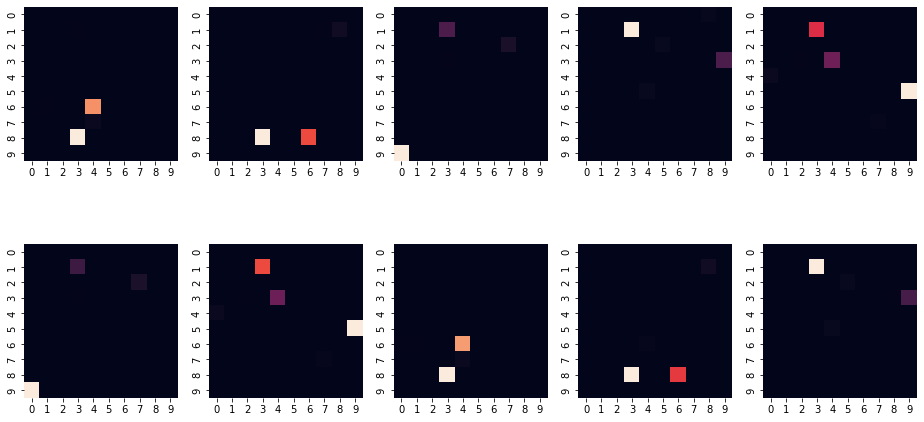

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplots(figsize=(16,8))
for factor in range(n_factors):
    plt.subplot(2,n_factors,factor+1)
    sns.heatmap(data=model.phi[factor].reshape((10,10)),square=True,cbar=False)
    plt.subplot(2,n_factors,factor+1+n_factors)
    sns.heatmap(data=phi[factor].reshape((10,10)),square=True,cbar=False)

# 显示图形
plt.show()

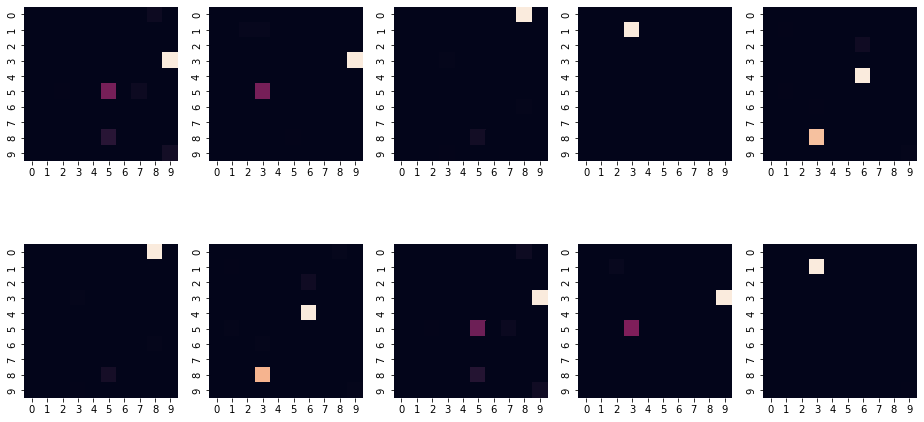

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplots(figsize=(16,8))
for factor in range(n_factors):
    plt.subplot(2,n_factors,factor+1)
    #plt.imshow(phi[factor].reshape((10,10)),cmap='cool')
    sns.heatmap(data=model.phi[factor+n_factors].reshape((10,10)),square=True,cbar=False)
    plt.subplot(2,n_factors,factor+1+n_factors)
    sns.heatmap(data=phi[factor+n_factors].reshape((10,10)),square=True,cbar=False)

# 显示图形
plt.show()

## UCL search

In [67]:
import gzip
import _pickle as cPickle

# load existing model
with gzip.open('./models/kappa0.5/model_united_reg0.05_lamb0.1.p', 'rb') as f:
    model = cPickle.load(f)

In [8]:
# =============================================================================
# Generate In-Control Data and Search UCL
# =============================================================================

print("monitoring score")

item_id = 0 # select a specific item
m = 100 # reference sample size
n = 5 # test sample size
n_permute = 10000 # number of random permutations
RL_trys = 10000 # number of trys for run lengths
lamb = 0.2 # smoothing parameter for EWMA
UCL_l = 0.6 # lower search bound of UCL
UCL_u = 0.7 # upper search bound of UCL 
UCL_0 = (UCL_l + UCL_u)/2
ARL = 0

print('ARL={}, next round search range: ({},{})'.format(ARL, UCL_l, UCL_u))

while abs(ARL-370) > 3:   
    RL = [] # to record each RL
    for k in range(RL_trys):
        # generate m reference samples
        ref_samples = []
        for i in range(m):
            residual = np.random.normal(scale=1.0)
            user_id = np.random.choice(np.arange(n_u))
            score = bias_user[user_id] + bias_item[item_id] + U_matrix[user_id].dot(V_matrix[item_id]) + residual
            #ref_samples.append(score-model.predict_rating(user_id,item_id))
            ref_samples.append(score)
        EWMA_j = 0
        cur_RL = 5000
        for j in range(1,5001):
            # generate n test samples
            test_samples = []
            for i in range(n):
                residual = np.random.normal(scale=1.0)
                user_id = np.random.choice(np.arange(n_u))
                score = bias_user[user_id] + bias_item[item_id] + U_matrix[user_id].dot(V_matrix[item_id]) + residual
                #test_samples.append(score-model.predict_rating(user_id,item_id))
                test_samples.append(score)
            # compute Wilcoxon Rank Sum statistic
            full_samples = pd.Series(ref_samples + test_samples)
            actual_ranks = full_samples.rank()
            WRS_actual = actual_ranks[m:].sum()
            
            # # random permuations to approximate p-value
            # count = 0
            # for permute in range(n_permute):
            #     p = np.random.permutation(full_samples)
            #     p_WRS = pd.Series(p).rank()[m:].sum()
            #     if p_WRS >= WRS_actual:
            #         count += 1
            # p_value = count/n_permute
            # # compute EWMA statistic
            # L_j = -1*np.log(p_value)
            # if j < 1:
            #     EWMA_j = L_j
            # else:
            #     EWMA_j = lamb*L_j + (1-lamb)*EWMA_j
            # if EWMA_j > UCL_0:
            #     print(RL)
            #     RL.append(j+1)
            #     break
            
            # monitoring EWMA of WRS statistic
            mean = n*(m+n+1)/2
            var = m*n*(m+n+1)/12
            WRS_actual = -1*(WRS_actual-mean)/np.sqrt(var)
            # compute EWMA statistic
            EWMA_j = lamb*WRS_actual + (1-lamb)*EWMA_j
            
            if EWMA_j > UCL_0:
                cur_RL = j
                break

        #print(j, EWMA_j)
        RL.append(cur_RL)
        if len(RL)%200 == 0:
            print(len(RL),np.mean(RL),np.std(RL)/np.sqrt(len(RL)))

            
    ARL = np.mean(RL)   
    if ARL < 370:
        UCL_l = UCL_0
        UCL_0 = (UCL_l+UCL_u)/2
    else:
        UCL_u = UCL_0
        UCL_0 = (UCL_l+UCL_u)/2
    print('ARL={}, ARL_std={}, next round search range: ({},{})'.format(ARL, np.std(RL)/np.sqrt(len(RL)), UCL_l, UCL_u))
    

print(np.mean(RL),np.std(RL)/np.sqrt(len(RL)))
  
#import matplotlib.pyplot as plt
#plt.hist(RL,range=(0,500),bins=50)

ARL=0, next round search range: (0.6,0.61)
14600 368.227602739726
14800 368.5689864864865
15000 367.3662
15200 365.2053289473684
15400 385.25837662337665
15600 382.2974358974359
15800 381.2868987341772
16000 381.158625
ARL=379.5087480680062, RL_std=4215.125272123194, next round search range: (0.6,0.605)
16200 379.2944444444444
16400 377.64548780487803
16600 375.12746987951806
16800 374.3595238095238
17000 372.3949411764706
17200 370.87226744186046
17400 370.3482183908046
17600 370.32693181818183
ARL=377.05243319268635, RL_std=4126.978081411614, next round search range: (0.6,0.6025)
17800 376.8125842696629
18000 375.6136666666667
18200 374.47076923076924
18400 373.1904347826087
18600 372.75193548387097
18800 371.26936170212764


KeyboardInterrupt: 

In [17]:
np.mean(RL), np.std(RL)/400

(371.1910225763612, 10.040915347002562)

In [16]:
np.sqrt(len(RL))

137.20422734012243

## Phase-II monitoring

In [5]:
import gzip
import _pickle as cPickle

# load existing model
with gzip.open('./models/kappa3/united_reg0.2_lamb0.01.p', 'rb') as f:
#with gzip.open('./models/kappa3/model_onlyrating.p', 'rb') as f:
    model = cPickle.load(f)

In [6]:
V_matrix[0]

array([-0.91946118,  0.11467003, -0.1374237 ,  1.36552692, -0.26163835])

In [63]:
# =============================================================================
# Risk-adjusted Monitoring of Out-of-Control Data
# =============================================================================
            
UCL = 0.1328
item_id = 0 # select a specific item
bias_item_shift = -0.25
factor_item_shift = np.array([0,0,0,-0.25,0])
m = 100 # reference sample size
n = 5 # test sample size
RL_trys = 80000 # number of trys for run lengths
lamb = 0.05 # smoothing parameter for EWMA

RL = []
for k in range(RL_trys):
    # generate m reference samples
    ref_samples = []
    for i in range(m):
        residual = np.random.normal(scale=1.0)
        user_id = np.random.choice(np.arange(n_u))        
        score = bias_user[user_id] + bias_item[item_id] + U_matrix[user_id].dot(V_matrix[item_id]) + residual
        #ref_samples.append(score)
        ref_samples.append(score-model.predict_rating(user_id,item_id))
    EWMA_j = 0
    cur_RL = 5000
    for j in range(1,5001):
        # generate n test samples
        test_samples = []
        for i in range(n):
            residual = np.random.normal(scale=1.0)
            user_id = np.random.choice(np.arange(n_u))  
            #score = bias_user[user_id] + bias_item[item_id] + U_matrix[user_id].dot(V_matrix[item_id]) + residual
            score = bias_user[user_id] + bias_item[item_id] + bias_item_shift + U_matrix[user_id].dot(V_matrix[item_id]) + residual
            #score = bias_user[user_id] + bias_item[item_id] + U_matrix[user_id].dot(V_matrix[item_id] + factor_item_shift) + residual
            #test_samples.append(score)
            test_samples.append(score-model.predict_rating(user_id,item_id))
        # compute Wilcoxon Rank Sum statistic
        full_samples = pd.Series(ref_samples + test_samples)
        actual_ranks = full_samples.rank()
        WRS_actual = actual_ranks[m:].sum()
        
        # monitoring EWMA of WRS statistic
        mean = n*(m+n+1)/2
        var = m*n*(m+n+1)/12
        WRS_actual = -1*(WRS_actual-mean)/np.sqrt(var)
        # compute EWMA statistic
        EWMA_j = lamb*WRS_actual + (1-lamb)*EWMA_j
        
        if EWMA_j > UCL:
            cur_RL = j
            break

    RL.append(cur_RL)
    if len(RL)%200 == 0:
        print(len(RL),np.mean(RL),np.std(RL)/np.sqrt(len(RL)))
        
ARL1 = np.mean(RL)         
print("ARL1: {}({})".format(ARL1, np.std(RL)/np.sqrt(len(RL))))
        

200 19.925 5.032896469727944
400 23.075 5.173184313118951
600 21.051666666666666 3.603774024213032
800 21.4875 3.298590104830774
1000 20.576 2.737840430704463
1200 19.055833333333332 2.2913004645540798
1400 18.623571428571427 1.9984796034943888
1600 18.20625 1.7673410838986168
1800 18.177777777777777 1.7137651775188654
2000 18.6955 1.9273532083857903
2200 18.47772727272727 1.7703118105980793
2400 17.814583333333335 1.6251051509560153
2600 18.127692307692307 1.5915566607760556
2800 17.682142857142857 1.4813473384509013
3000 18.082666666666668 1.5185081677117864
3200 18.5915625 1.5873280902302258
3400 18.32029411764706 1.4979738969095249
3600 18.571944444444444 1.4722765547204062
3800 18.575 1.412950014725777
4000 18.2535 1.3433504510876901
4200 18.000714285714285 1.2807547421848922
4400 17.654545454545456 1.223310753590328
4600 17.762608695652172 1.1855160627357693
4800 17.632083333333334 1.1388349968882419
5000 17.5882 1.102901284862793
5200 17.471923076923076 1.0662126034974686
5400 1

KeyboardInterrupt: 

## Diagnosis

In [25]:
import gzip
import _pickle as cPickle
from dataset import Dataset
from Model2_c import Model

# load existing model
with gzip.open('./models/kappa3/united/united_reg0.2_lamb0.015.p', 'rb') as f:
    model = cPickle.load(f)

In [37]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import cosine_similarity

# match the predicted topics with the ground truth by Hungarian Algorithm
cost = np.zeros((n_factors, n_factors))
for i in range(n_factors):
    for j in range(n_factors):
        cost[i,j] = 1 - cosine_similarity(phi[i].reshape(1,-1),model.phi[j].reshape(1,-1))[0][0] 

row_ind, col_ind = linear_sum_assignment(cost)
col_ind # map from estimated topic index to the ground truth topic index

array([2, 4, 0, 1, 3], dtype=int64)

In [38]:
V_matrix[0]

array([-0.91946118,  0.11467003, -0.1374237 ,  1.36552692, -0.26163835])

In [45]:
# =============================================================================
# Diagnosis for the OOC term
# =============================================================================

item_id = 0 # select a specific item
j = model.trainset.raw2inner_id_items[item_id]
shift_scale = -1
n_OOC_samples = 100 # number of OOC samples for diagnosis in each experiment
n_experiments = 500

hit_count = 0
# generate OOC samples
for experiment in range(1,n_experiments+1):
    samples = []
    factor_item_shift = np.zeros(n_factors)
    # randomly select a shifting factor
    select_k = np.random.choice(np.arange(n_factors))
    factor_item_shift[select_k] = shift_scale
    for sample in range(n_OOC_samples):
        residual = np.random.normal(scale=1.0)
        user_id = np.random.choice(np.arange(n_u))   
        score = bias_user[user_id] + bias_item[item_id] + U_matrix[user_id].dot(V_matrix[item_id] + factor_item_shift) + residual
        theta_pos = np.exp(kappa * U_matrix[user_id] * (V_matrix[item_id] + factor_item_shift))
        theta_neg = np.exp(-1 * kappa * U_matrix[user_id] * (V_matrix[item_id] + factor_item_shift))
        theta = np.concatenate((theta_pos,theta_neg))    
        theta /= np.sum(theta)
        doc = []
        for n in range(n_w):
            k = np.random.choice(np.arange(n_factors*2),p=theta)
            w = np.random.choice(np.arange(V),p=phi[k])
            doc.append(w)
        samples.append([user_id,item_id,score,doc])
    df_OOC = pd.DataFrame(samples, columns = ['user','item','rating','review'])
    b_j, v_j = model.online_item_inference(irid=item_id, new_corpus = df_OOC, lr_sgd = 0.005, epochs=10, diagnosis_reg=0.2)        
    delta_v_j = v_j - model.V[j]
    # transform v_j by matching the ground truth topic indices
    delta_v_j = [delta_v_j[col_ind[i]] for i in range(n_factors)]
    if np.argmin(delta_v_j) == select_k:
        hit_count += 1
    print(experiment,"hit rate:",hit_count/experiment)

1 hit rate: 1.0
2 hit rate: 0.5
3 hit rate: 0.6666666666666666
4 hit rate: 0.75
5 hit rate: 0.6
6 hit rate: 0.5
7 hit rate: 0.5714285714285714
8 hit rate: 0.5
9 hit rate: 0.5555555555555556
10 hit rate: 0.6
11 hit rate: 0.5454545454545454
12 hit rate: 0.5833333333333334
13 hit rate: 0.6153846153846154
14 hit rate: 0.5714285714285714
15 hit rate: 0.6
16 hit rate: 0.625
17 hit rate: 0.6470588235294118
18 hit rate: 0.6111111111111112
19 hit rate: 0.5789473684210527
20 hit rate: 0.55
21 hit rate: 0.5238095238095238
22 hit rate: 0.5
23 hit rate: 0.5217391304347826
24 hit rate: 0.5416666666666666
25 hit rate: 0.52
26 hit rate: 0.5
27 hit rate: 0.48148148148148145
28 hit rate: 0.5
29 hit rate: 0.4827586206896552
30 hit rate: 0.4666666666666667
31 hit rate: 0.45161290322580644
32 hit rate: 0.46875
33 hit rate: 0.45454545454545453
34 hit rate: 0.47058823529411764
35 hit rate: 0.4857142857142857
36 hit rate: 0.4722222222222222
37 hit rate: 0.4864864864864865
38 hit rate: 0.47368421052631576
39 h

267 hit rate: 0.6404494382022472
268 hit rate: 0.6380597014925373
269 hit rate: 0.6356877323420075
270 hit rate: 0.6370370370370371
271 hit rate: 0.6383763837638377
272 hit rate: 0.6397058823529411
273 hit rate: 0.6410256410256411
274 hit rate: 0.6423357664233577
275 hit rate: 0.64
276 hit rate: 0.6376811594202898
277 hit rate: 0.6389891696750902
278 hit rate: 0.6402877697841727
279 hit rate: 0.6415770609318996
280 hit rate: 0.6428571428571429
281 hit rate: 0.6405693950177936
282 hit rate: 0.6418439716312057
283 hit rate: 0.6395759717314488
284 hit rate: 0.6373239436619719
285 hit rate: 0.6350877192982456
286 hit rate: 0.6328671328671329
287 hit rate: 0.6306620209059234
288 hit rate: 0.6319444444444444
289 hit rate: 0.6332179930795848
290 hit rate: 0.6344827586206897
291 hit rate: 0.6357388316151202
292 hit rate: 0.6335616438356164
293 hit rate: 0.6348122866894198
294 hit rate: 0.6326530612244898
295 hit rate: 0.6305084745762712
296 hit rate: 0.6317567567567568
297 hit rate: 0.62962962

In [47]:
item_id = 0 # select a specific item
j = model.trainset.raw2inner_id_items[item_id]
n_OOC_samples = 100 # number of OOC samples for diagnosis in each experiment
n_experiments = 500

for shift_scale in [-0.25,-0.5,-0.75,-1]:
    for diagnosis_reg in [0,0.1,0.2,0.3,0.4]:
        hit_count = 0
        # generate OOC samples
        for experiment in range(1,n_experiments+1):
            samples = []
            factor_item_shift = np.zeros(n_factors)
            # randomly select a shifting factor
            select_k = np.random.choice(np.arange(n_factors))
            factor_item_shift[select_k] = shift_scale
            for sample in range(n_OOC_samples):
                residual = np.random.normal(scale=1.0)
                user_id = np.random.choice(np.arange(n_u))   
                score = bias_user[user_id] + bias_item[item_id] + U_matrix[user_id].dot(V_matrix[item_id] + factor_item_shift) + residual
                theta_pos = np.exp(kappa * U_matrix[user_id] * (V_matrix[item_id] + factor_item_shift))
                theta_neg = np.exp(-1 * kappa * U_matrix[user_id] * (V_matrix[item_id] + factor_item_shift))
                theta = np.concatenate((theta_pos,theta_neg))    
                theta /= np.sum(theta)
                doc = []
                for n in range(n_w):
                    k = np.random.choice(np.arange(n_factors*2),p=theta)
                    w = np.random.choice(np.arange(V),p=phi[k])
                    doc.append(w)
                samples.append([user_id,item_id,score,doc])
            df_OOC = pd.DataFrame(samples, columns = ['user','item','rating','review'])
            b_j, v_j = model.online_item_inference(irid=item_id, new_corpus = df_OOC, lr_sgd = 0.005, epochs=10, diagnosis_reg=diagnosis_reg)        
            delta_v_j = v_j - model.V[j]
            # transform v_j by matching the ground truth topic indices
            delta_v_j = [delta_v_j[col_ind[i]] for i in range(n_factors)]
            if np.argmin(delta_v_j) == select_k:
                hit_count += 1
            print(experiment,"hit rate:",hit_count/experiment)
        print("******",shift_scale,diagnosis_reg,hit_count/n_experiments,"******")

1 hit rate: 0.0
2 hit rate: 0.0
3 hit rate: 0.3333333333333333
4 hit rate: 0.25
5 hit rate: 0.2
6 hit rate: 0.16666666666666666
7 hit rate: 0.2857142857142857
8 hit rate: 0.375
9 hit rate: 0.3333333333333333
10 hit rate: 0.3
11 hit rate: 0.2727272727272727
12 hit rate: 0.25
13 hit rate: 0.3076923076923077
14 hit rate: 0.2857142857142857
15 hit rate: 0.26666666666666666
16 hit rate: 0.3125
17 hit rate: 0.29411764705882354
18 hit rate: 0.2777777777777778
19 hit rate: 0.2631578947368421
20 hit rate: 0.25
21 hit rate: 0.23809523809523808
22 hit rate: 0.22727272727272727
23 hit rate: 0.2608695652173913
24 hit rate: 0.2916666666666667
25 hit rate: 0.28
26 hit rate: 0.2692307692307692
27 hit rate: 0.25925925925925924
28 hit rate: 0.2857142857142857
29 hit rate: 0.27586206896551724
30 hit rate: 0.26666666666666666
31 hit rate: 0.25806451612903225
32 hit rate: 0.25
33 hit rate: 0.24242424242424243
34 hit rate: 0.2647058823529412
35 hit rate: 0.2571428571428571
36 hit rate: 0.25
37 hit rate: 0.2

262 hit rate: 0.3549618320610687
263 hit rate: 0.3574144486692015
264 hit rate: 0.3560606060606061
265 hit rate: 0.35471698113207545
266 hit rate: 0.3533834586466165
267 hit rate: 0.352059925093633
268 hit rate: 0.35074626865671643
269 hit rate: 0.34944237918215615
270 hit rate: 0.35185185185185186
271 hit rate: 0.3505535055350554
272 hit rate: 0.35294117647058826
273 hit rate: 0.3516483516483517
274 hit rate: 0.354014598540146
275 hit rate: 0.3563636363636364
276 hit rate: 0.358695652173913
277 hit rate: 0.36101083032490977
278 hit rate: 0.3597122302158273
279 hit rate: 0.35842293906810035
280 hit rate: 0.35714285714285715
281 hit rate: 0.3594306049822064
282 hit rate: 0.35815602836879434
283 hit rate: 0.3568904593639576
284 hit rate: 0.35563380281690143
285 hit rate: 0.3543859649122807
286 hit rate: 0.3531468531468531
287 hit rate: 0.3554006968641115
288 hit rate: 0.3576388888888889
289 hit rate: 0.356401384083045
290 hit rate: 0.3586206896551724
291 hit rate: 0.36082474226804123
292

13 hit rate: 0.38461538461538464
14 hit rate: 0.35714285714285715
15 hit rate: 0.3333333333333333
16 hit rate: 0.375
17 hit rate: 0.35294117647058826
18 hit rate: 0.3333333333333333
19 hit rate: 0.3684210526315789
20 hit rate: 0.35
21 hit rate: 0.38095238095238093
22 hit rate: 0.36363636363636365
23 hit rate: 0.34782608695652173
24 hit rate: 0.3333333333333333
25 hit rate: 0.32
26 hit rate: 0.3076923076923077
27 hit rate: 0.3333333333333333
28 hit rate: 0.35714285714285715
29 hit rate: 0.3793103448275862
30 hit rate: 0.4
31 hit rate: 0.41935483870967744
32 hit rate: 0.4375
33 hit rate: 0.45454545454545453
34 hit rate: 0.4411764705882353
35 hit rate: 0.45714285714285713
36 hit rate: 0.4444444444444444
37 hit rate: 0.4594594594594595
38 hit rate: 0.47368421052631576
39 hit rate: 0.48717948717948717
40 hit rate: 0.5
41 hit rate: 0.4878048780487805
42 hit rate: 0.5
43 hit rate: 0.5116279069767442
44 hit rate: 0.5227272727272727
45 hit rate: 0.5111111111111111
46 hit rate: 0.5
47 hit rate: 

274 hit rate: 0.3613138686131387
275 hit rate: 0.36363636363636365
276 hit rate: 0.36231884057971014
277 hit rate: 0.36462093862815886
278 hit rate: 0.36330935251798563
279 hit rate: 0.3655913978494624
280 hit rate: 0.3678571428571429
281 hit rate: 0.3701067615658363
282 hit rate: 0.3723404255319149
283 hit rate: 0.3745583038869258
284 hit rate: 0.3767605633802817
285 hit rate: 0.37894736842105264
286 hit rate: 0.3776223776223776
287 hit rate: 0.37630662020905925
288 hit rate: 0.375
289 hit rate: 0.3771626297577855
290 hit rate: 0.3793103448275862
291 hit rate: 0.38144329896907214
292 hit rate: 0.3801369863013699
293 hit rate: 0.378839590443686
294 hit rate: 0.38095238095238093
295 hit rate: 0.37966101694915255
296 hit rate: 0.38175675675675674
297 hit rate: 0.3838383838383838
298 hit rate: 0.3825503355704698
299 hit rate: 0.38461538461538464
300 hit rate: 0.38333333333333336
301 hit rate: 0.38205980066445183
302 hit rate: 0.38079470198675497
303 hit rate: 0.38283828382838286
304 hit r

26 hit rate: 0.4230769230769231
27 hit rate: 0.4444444444444444
28 hit rate: 0.42857142857142855
29 hit rate: 0.41379310344827586
30 hit rate: 0.43333333333333335
31 hit rate: 0.41935483870967744
32 hit rate: 0.40625
33 hit rate: 0.42424242424242425
34 hit rate: 0.4411764705882353
35 hit rate: 0.42857142857142855
36 hit rate: 0.4444444444444444
37 hit rate: 0.43243243243243246
38 hit rate: 0.4473684210526316
39 hit rate: 0.4358974358974359
40 hit rate: 0.45
41 hit rate: 0.4634146341463415
42 hit rate: 0.47619047619047616
43 hit rate: 0.46511627906976744
44 hit rate: 0.4772727272727273
45 hit rate: 0.4666666666666667
46 hit rate: 0.4782608695652174
47 hit rate: 0.46808510638297873
48 hit rate: 0.4583333333333333
49 hit rate: 0.46938775510204084
50 hit rate: 0.48
51 hit rate: 0.49019607843137253
52 hit rate: 0.4807692307692308
53 hit rate: 0.49056603773584906
54 hit rate: 0.5
55 hit rate: 0.4909090909090909
56 hit rate: 0.5
57 hit rate: 0.49122807017543857
58 hit rate: 0.5
59 hit rate: 0

287 hit rate: 0.49477351916376305
288 hit rate: 0.4965277777777778
289 hit rate: 0.49480968858131485
290 hit rate: 0.49310344827586206
291 hit rate: 0.49140893470790376
292 hit rate: 0.4897260273972603
293 hit rate: 0.4880546075085324
294 hit rate: 0.48639455782312924
295 hit rate: 0.488135593220339
296 hit rate: 0.4864864864864865
297 hit rate: 0.4882154882154882
298 hit rate: 0.4865771812080537
299 hit rate: 0.48494983277591974
300 hit rate: 0.48333333333333334
301 hit rate: 0.48172757475083056
302 hit rate: 0.48344370860927155
303 hit rate: 0.48184818481848185
304 hit rate: 0.48026315789473684
305 hit rate: 0.4786885245901639
306 hit rate: 0.4803921568627451
307 hit rate: 0.4820846905537459
308 hit rate: 0.4805194805194805
309 hit rate: 0.48220064724919093
310 hit rate: 0.4806451612903226
311 hit rate: 0.4790996784565916
312 hit rate: 0.4807692307692308
313 hit rate: 0.4792332268370607
314 hit rate: 0.48089171974522293
315 hit rate: 0.4793650793650794
316 hit rate: 0.477848101265822

42 hit rate: 0.4523809523809524
43 hit rate: 0.4418604651162791
44 hit rate: 0.45454545454545453
45 hit rate: 0.4444444444444444
46 hit rate: 0.43478260869565216
47 hit rate: 0.44680851063829785
48 hit rate: 0.4583333333333333
49 hit rate: 0.4489795918367347
50 hit rate: 0.44
51 hit rate: 0.43137254901960786
52 hit rate: 0.4423076923076923
53 hit rate: 0.4339622641509434
54 hit rate: 0.4444444444444444
55 hit rate: 0.43636363636363634
56 hit rate: 0.42857142857142855
57 hit rate: 0.43859649122807015
58 hit rate: 0.4482758620689655
59 hit rate: 0.4576271186440678
60 hit rate: 0.4666666666666667
61 hit rate: 0.47540983606557374
62 hit rate: 0.46774193548387094
63 hit rate: 0.4603174603174603
64 hit rate: 0.453125
65 hit rate: 0.4461538461538462
66 hit rate: 0.4393939393939394
67 hit rate: 0.44776119402985076
68 hit rate: 0.45588235294117646
69 hit rate: 0.4492753623188406
70 hit rate: 0.44285714285714284
71 hit rate: 0.43661971830985913
72 hit rate: 0.4305555555555556
73 hit rate: 0.4246

295 hit rate: 0.4271186440677966
296 hit rate: 0.42567567567567566
297 hit rate: 0.42424242424242425
298 hit rate: 0.4228187919463087
299 hit rate: 0.42474916387959866
300 hit rate: 0.42333333333333334
301 hit rate: 0.42524916943521596
302 hit rate: 0.4271523178807947
303 hit rate: 0.429042904290429
304 hit rate: 0.4309210526315789
305 hit rate: 0.42950819672131146
306 hit rate: 0.42810457516339867
307 hit rate: 0.42996742671009774
308 hit rate: 0.4318181818181818
309 hit rate: 0.4336569579288026
310 hit rate: 0.432258064516129
311 hit rate: 0.43086816720257237
312 hit rate: 0.4326923076923077
313 hit rate: 0.43130990415335463
314 hit rate: 0.4299363057324841
315 hit rate: 0.43174603174603177
316 hit rate: 0.43354430379746833
317 hit rate: 0.43217665615141954
318 hit rate: 0.4308176100628931
319 hit rate: 0.42946708463949845
320 hit rate: 0.428125
321 hit rate: 0.42679127725856697
322 hit rate: 0.4254658385093168
323 hit rate: 0.4241486068111455
324 hit rate: 0.4228395061728395
325 hit

48 hit rate: 0.4166666666666667
49 hit rate: 0.40816326530612246
50 hit rate: 0.42
51 hit rate: 0.4117647058823529
52 hit rate: 0.4230769230769231
53 hit rate: 0.4339622641509434
54 hit rate: 0.42592592592592593
55 hit rate: 0.43636363636363634
56 hit rate: 0.44642857142857145
57 hit rate: 0.43859649122807015
58 hit rate: 0.43103448275862066
59 hit rate: 0.4406779661016949
60 hit rate: 0.43333333333333335
61 hit rate: 0.4262295081967213
62 hit rate: 0.41935483870967744
63 hit rate: 0.4126984126984127
64 hit rate: 0.40625
65 hit rate: 0.4
66 hit rate: 0.3939393939393939
67 hit rate: 0.3880597014925373
68 hit rate: 0.39705882352941174
69 hit rate: 0.4057971014492754
70 hit rate: 0.4
71 hit rate: 0.39436619718309857
72 hit rate: 0.4027777777777778
73 hit rate: 0.410958904109589
74 hit rate: 0.40540540540540543
75 hit rate: 0.41333333333333333
76 hit rate: 0.42105263157894735
77 hit rate: 0.4155844155844156
78 hit rate: 0.41025641025641024
79 hit rate: 0.4177215189873418
80 hit rate: 0.412

301 hit rate: 0.4584717607973422
302 hit rate: 0.4602649006622517
303 hit rate: 0.45874587458745875
304 hit rate: 0.4605263157894737
305 hit rate: 0.45901639344262296
306 hit rate: 0.46078431372549017
307 hit rate: 0.4592833876221498
308 hit rate: 0.461038961038961
309 hit rate: 0.4627831715210356
310 hit rate: 0.4645161290322581
311 hit rate: 0.4630225080385852
312 hit rate: 0.46153846153846156
313 hit rate: 0.46325878594249204
314 hit rate: 0.46178343949044587
315 hit rate: 0.4603174603174603
316 hit rate: 0.4588607594936709
317 hit rate: 0.45741324921135645
318 hit rate: 0.4591194968553459
319 hit rate: 0.4608150470219436
320 hit rate: 0.459375
321 hit rate: 0.46105919003115264
322 hit rate: 0.45962732919254656
323 hit rate: 0.4582043343653251
324 hit rate: 0.45987654320987653
325 hit rate: 0.4584615384615385
326 hit rate: 0.4570552147239264
327 hit rate: 0.45565749235474007
328 hit rate: 0.45426829268292684
329 hit rate: 0.45288753799392095
330 hit rate: 0.45454545454545453
331 hit

58 hit rate: 0.4482758620689655
59 hit rate: 0.4406779661016949
60 hit rate: 0.45
61 hit rate: 0.45901639344262296
62 hit rate: 0.46774193548387094
63 hit rate: 0.47619047619047616
64 hit rate: 0.484375
65 hit rate: 0.49230769230769234
66 hit rate: 0.48484848484848486
67 hit rate: 0.47761194029850745
68 hit rate: 0.47058823529411764
69 hit rate: 0.4782608695652174
70 hit rate: 0.4714285714285714
71 hit rate: 0.4788732394366197
72 hit rate: 0.4861111111111111
73 hit rate: 0.4794520547945205
74 hit rate: 0.4864864864864865
75 hit rate: 0.49333333333333335
76 hit rate: 0.5
77 hit rate: 0.4935064935064935
78 hit rate: 0.48717948717948717
79 hit rate: 0.4810126582278481
80 hit rate: 0.475
81 hit rate: 0.4691358024691358
82 hit rate: 0.47560975609756095
83 hit rate: 0.46987951807228917
84 hit rate: 0.47619047619047616
85 hit rate: 0.4823529411764706
86 hit rate: 0.4883720930232558
87 hit rate: 0.4942528735632184
88 hit rate: 0.48863636363636365
89 hit rate: 0.48314606741573035
90 hit rate: 0

317 hit rate: 0.501577287066246
318 hit rate: 0.5031446540880503
319 hit rate: 0.5015673981191222
320 hit rate: 0.5
321 hit rate: 0.5015576323987538
322 hit rate: 0.5
323 hit rate: 0.5015479876160991
324 hit rate: 0.5
325 hit rate: 0.5015384615384615
326 hit rate: 0.5
327 hit rate: 0.5015290519877675
328 hit rate: 0.5
329 hit rate: 0.49848024316109424
330 hit rate: 0.5
331 hit rate: 0.5015105740181269
332 hit rate: 0.5
333 hit rate: 0.4984984984984985
334 hit rate: 0.49700598802395207
335 hit rate: 0.4955223880597015
336 hit rate: 0.49404761904761907
337 hit rate: 0.49258160237388726
338 hit rate: 0.4911242603550296
339 hit rate: 0.49262536873156343
340 hit rate: 0.49117647058823527
341 hit rate: 0.49266862170087977
342 hit rate: 0.49122807017543857
343 hit rate: 0.49271137026239065
344 hit rate: 0.49127906976744184
345 hit rate: 0.4927536231884058
346 hit rate: 0.49421965317919075
347 hit rate: 0.4956772334293948
348 hit rate: 0.4942528735632184
349 hit rate: 0.49570200573065903
350 h

80 hit rate: 0.5
81 hit rate: 0.49382716049382713
82 hit rate: 0.5
83 hit rate: 0.4939759036144578
84 hit rate: 0.5
85 hit rate: 0.49411764705882355
86 hit rate: 0.4883720930232558
87 hit rate: 0.4827586206896552
88 hit rate: 0.4772727272727273
89 hit rate: 0.47191011235955055
90 hit rate: 0.4777777777777778
91 hit rate: 0.4725274725274725
92 hit rate: 0.4673913043478261
93 hit rate: 0.4731182795698925
94 hit rate: 0.4787234042553192
95 hit rate: 0.4842105263157895
96 hit rate: 0.4895833333333333
97 hit rate: 0.4948453608247423
98 hit rate: 0.4897959183673469
99 hit rate: 0.494949494949495
100 hit rate: 0.49
101 hit rate: 0.49504950495049505
102 hit rate: 0.5
103 hit rate: 0.5048543689320388
104 hit rate: 0.5096153846153846
105 hit rate: 0.5142857142857142
106 hit rate: 0.5188679245283019
107 hit rate: 0.5233644859813084
108 hit rate: 0.5277777777777778
109 hit rate: 0.5229357798165137
110 hit rate: 0.5272727272727272
111 hit rate: 0.5315315315315315
112 hit rate: 0.5357142857142857
11

338 hit rate: 0.5236686390532544
339 hit rate: 0.5221238938053098
340 hit rate: 0.5205882352941177
341 hit rate: 0.5190615835777126
342 hit rate: 0.5175438596491229
343 hit rate: 0.5189504373177842
344 hit rate: 0.5174418604651163
345 hit rate: 0.518840579710145
346 hit rate: 0.5202312138728323
347 hit rate: 0.521613832853026
348 hit rate: 0.5201149425287356
349 hit rate: 0.5214899713467048
350 hit rate: 0.52
351 hit rate: 0.5213675213675214
352 hit rate: 0.5198863636363636
353 hit rate: 0.5212464589235127
354 hit rate: 0.519774011299435
355 hit rate: 0.5211267605633803
356 hit rate: 0.5196629213483146
357 hit rate: 0.5210084033613446
358 hit rate: 0.5223463687150838
359 hit rate: 0.520891364902507
360 hit rate: 0.5222222222222223
361 hit rate: 0.5207756232686981
362 hit rate: 0.5193370165745856
363 hit rate: 0.5179063360881543
364 hit rate: 0.5164835164835165
365 hit rate: 0.5178082191780822
366 hit rate: 0.5191256830601093
367 hit rate: 0.5204359673024523
368 hit rate: 0.521739130434

100 hit rate: 0.55
101 hit rate: 0.5445544554455446
102 hit rate: 0.5490196078431373
103 hit rate: 0.5436893203883495
104 hit rate: 0.5480769230769231
105 hit rate: 0.5523809523809524
106 hit rate: 0.5566037735849056
107 hit rate: 0.5514018691588785
108 hit rate: 0.5555555555555556
109 hit rate: 0.5596330275229358
110 hit rate: 0.5636363636363636
111 hit rate: 0.5675675675675675
112 hit rate: 0.5625
113 hit rate: 0.5663716814159292
114 hit rate: 0.5614035087719298
115 hit rate: 0.5652173913043478
116 hit rate: 0.5603448275862069
117 hit rate: 0.5555555555555556
118 hit rate: 0.559322033898305
119 hit rate: 0.5546218487394958
120 hit rate: 0.5583333333333333
121 hit rate: 0.5619834710743802
122 hit rate: 0.5573770491803278
123 hit rate: 0.5528455284552846
124 hit rate: 0.5483870967741935
125 hit rate: 0.552
126 hit rate: 0.5555555555555556
127 hit rate: 0.5590551181102362
128 hit rate: 0.5546875
129 hit rate: 0.5581395348837209
130 hit rate: 0.5538461538461539
131 hit rate: 0.5572519083

354 hit rate: 0.556497175141243
355 hit rate: 0.5577464788732395
356 hit rate: 0.5561797752808989
357 hit rate: 0.5574229691876751
358 hit rate: 0.5586592178770949
359 hit rate: 0.5598885793871866
360 hit rate: 0.5583333333333333
361 hit rate: 0.5595567867036011
362 hit rate: 0.5580110497237569
363 hit rate: 0.5564738292011019
364 hit rate: 0.5576923076923077
365 hit rate: 0.5589041095890411
366 hit rate: 0.5601092896174863
367 hit rate: 0.5613079019073569
368 hit rate: 0.5597826086956522
369 hit rate: 0.5609756097560976
370 hit rate: 0.5621621621621622
371 hit rate: 0.5606469002695418
372 hit rate: 0.5591397849462365
373 hit rate: 0.5603217158176944
374 hit rate: 0.5614973262032086
375 hit rate: 0.5626666666666666
376 hit rate: 0.5611702127659575
377 hit rate: 0.5596816976127321
378 hit rate: 0.5608465608465608
379 hit rate: 0.5593667546174143
380 hit rate: 0.5605263157894737
381 hit rate: 0.5616797900262467
382 hit rate: 0.56282722513089
383 hit rate: 0.5639686684073107
384 hit rate:

120 hit rate: 0.5083333333333333
121 hit rate: 0.5041322314049587
122 hit rate: 0.5
123 hit rate: 0.4959349593495935
124 hit rate: 0.5
125 hit rate: 0.496
126 hit rate: 0.5
127 hit rate: 0.5039370078740157
128 hit rate: 0.5078125
129 hit rate: 0.5038759689922481
130 hit rate: 0.5
131 hit rate: 0.4961832061068702
132 hit rate: 0.5
133 hit rate: 0.5037593984962406
134 hit rate: 0.5
135 hit rate: 0.5037037037037037
136 hit rate: 0.5
137 hit rate: 0.5036496350364964
138 hit rate: 0.5
139 hit rate: 0.5035971223021583
140 hit rate: 0.5071428571428571
141 hit rate: 0.5106382978723404
142 hit rate: 0.5070422535211268
143 hit rate: 0.5104895104895105
144 hit rate: 0.5069444444444444
145 hit rate: 0.5103448275862069
146 hit rate: 0.5136986301369864
147 hit rate: 0.5102040816326531
148 hit rate: 0.5067567567567568
149 hit rate: 0.5033557046979866
150 hit rate: 0.5
151 hit rate: 0.4966887417218543
152 hit rate: 0.4934210526315789
153 hit rate: 0.49673202614379086
154 hit rate: 0.5
155 hit rate: 0.

378 hit rate: 0.5370370370370371
379 hit rate: 0.5356200527704486
380 hit rate: 0.5368421052631579
381 hit rate: 0.5380577427821522
382 hit rate: 0.5366492146596858
383 hit rate: 0.5352480417754569
384 hit rate: 0.5364583333333334
385 hit rate: 0.535064935064935
386 hit rate: 0.533678756476684
387 hit rate: 0.5322997416020672
388 hit rate: 0.5335051546391752
389 hit rate: 0.5347043701799485
390 hit rate: 0.5358974358974359
391 hit rate: 0.5370843989769821
392 hit rate: 0.5382653061224489
393 hit rate: 0.5368956743002544
394 hit rate: 0.5380710659898477
395 hit rate: 0.5392405063291139
396 hit rate: 0.5404040404040404
397 hit rate: 0.5415617128463476
398 hit rate: 0.542713567839196
399 hit rate: 0.543859649122807
400 hit rate: 0.545
401 hit rate: 0.543640897755611
402 hit rate: 0.5447761194029851
403 hit rate: 0.543424317617866
404 hit rate: 0.5445544554455446
405 hit rate: 0.5456790123456791
406 hit rate: 0.5443349753694581
407 hit rate: 0.5454545454545454
408 hit rate: 0.5441176470588

142 hit rate: 0.5985915492957746
143 hit rate: 0.5944055944055944
144 hit rate: 0.5972222222222222
145 hit rate: 0.6
146 hit rate: 0.5958904109589042
147 hit rate: 0.5918367346938775
148 hit rate: 0.5945945945945946
149 hit rate: 0.5906040268456376
150 hit rate: 0.5866666666666667
151 hit rate: 0.5894039735099338
152 hit rate: 0.5921052631578947
153 hit rate: 0.5947712418300654
154 hit rate: 0.5909090909090909
155 hit rate: 0.5870967741935483
156 hit rate: 0.5897435897435898
157 hit rate: 0.5859872611464968
158 hit rate: 0.5822784810126582
159 hit rate: 0.5786163522012578
160 hit rate: 0.58125
161 hit rate: 0.5838509316770186
162 hit rate: 0.5802469135802469
163 hit rate: 0.5766871165644172
164 hit rate: 0.573170731707317
165 hit rate: 0.5696969696969697
166 hit rate: 0.5662650602409639
167 hit rate: 0.562874251497006
168 hit rate: 0.5595238095238095
169 hit rate: 0.5562130177514792
170 hit rate: 0.5529411764705883
171 hit rate: 0.5497076023391813
172 hit rate: 0.5523255813953488
173 h

394 hit rate: 0.5228426395939086
395 hit rate: 0.5240506329113924
396 hit rate: 0.5252525252525253
397 hit rate: 0.5264483627204031
398 hit rate: 0.5276381909547738
399 hit rate: 0.5263157894736842
400 hit rate: 0.525
401 hit rate: 0.5261845386533666
402 hit rate: 0.527363184079602
403 hit rate: 0.5260545905707196
404 hit rate: 0.5247524752475248
405 hit rate: 0.5234567901234568
406 hit rate: 0.5221674876847291
407 hit rate: 0.5208845208845209
408 hit rate: 0.5220588235294118
409 hit rate: 0.5232273838630807
410 hit rate: 0.524390243902439
411 hit rate: 0.5255474452554745
412 hit rate: 0.5242718446601942
413 hit rate: 0.5254237288135594
414 hit rate: 0.5241545893719807
415 hit rate: 0.5253012048192771
416 hit rate: 0.5264423076923077
417 hit rate: 0.5251798561151079
418 hit rate: 0.5239234449760766
419 hit rate: 0.522673031026253
420 hit rate: 0.5214285714285715
421 hit rate: 0.5201900237529691
422 hit rate: 0.518957345971564
423 hit rate: 0.5177304964539007
424 hit rate: 0.51886792452

156 hit rate: 0.5576923076923077
157 hit rate: 0.5605095541401274
158 hit rate: 0.5632911392405063
159 hit rate: 0.559748427672956
160 hit rate: 0.5625
161 hit rate: 0.5652173913043478
162 hit rate: 0.5617283950617284
163 hit rate: 0.5644171779141104
164 hit rate: 0.5670731707317073
165 hit rate: 0.5636363636363636
166 hit rate: 0.5602409638554217
167 hit rate: 0.5568862275449101
168 hit rate: 0.5595238095238095
169 hit rate: 0.5621301775147929
170 hit rate: 0.5647058823529412
171 hit rate: 0.5614035087719298
172 hit rate: 0.563953488372093
173 hit rate: 0.5606936416184971
174 hit rate: 0.5574712643678161
175 hit rate: 0.56
176 hit rate: 0.5568181818181818
177 hit rate: 0.559322033898305
178 hit rate: 0.5561797752808989
179 hit rate: 0.5586592178770949
180 hit rate: 0.5611111111111111
181 hit rate: 0.5580110497237569
182 hit rate: 0.5604395604395604
183 hit rate: 0.5628415300546448
184 hit rate: 0.5597826086956522
185 hit rate: 0.5621621621621622
186 hit rate: 0.5645161290322581
187 hi

410 hit rate: 0.5609756097560976
411 hit rate: 0.559610705596107
412 hit rate: 0.5606796116504854
413 hit rate: 0.5617433414043583
414 hit rate: 0.5628019323671497
415 hit rate: 0.5614457831325301
416 hit rate: 0.5625
417 hit rate: 0.5611510791366906
418 hit rate: 0.562200956937799
419 hit rate: 0.5608591885441527
420 hit rate: 0.5595238095238095
421 hit rate: 0.5581947743467933
422 hit rate: 0.5592417061611374
423 hit rate: 0.5602836879432624
424 hit rate: 0.5613207547169812
425 hit rate: 0.5623529411764706
426 hit rate: 0.5610328638497653
427 hit rate: 0.5597189695550351
428 hit rate: 0.5584112149532711
429 hit rate: 0.5594405594405595
430 hit rate: 0.5604651162790698
431 hit rate: 0.5591647331786543
432 hit rate: 0.5601851851851852
433 hit rate: 0.5612009237875288
434 hit rate: 0.5599078341013825
435 hit rate: 0.5609195402298851
436 hit rate: 0.5619266055045872
437 hit rate: 0.5606407322654462
438 hit rate: 0.5616438356164384
439 hit rate: 0.5603644646924829
440 hit rate: 0.55909090

172 hit rate: 0.5697674418604651
173 hit rate: 0.5664739884393064
174 hit rate: 0.5689655172413793
175 hit rate: 0.5714285714285714
176 hit rate: 0.5681818181818182
177 hit rate: 0.5706214689265536
178 hit rate: 0.5674157303370787
179 hit rate: 0.5698324022346368
180 hit rate: 0.5722222222222222
181 hit rate: 0.574585635359116
182 hit rate: 0.5769230769230769
183 hit rate: 0.5737704918032787
184 hit rate: 0.5760869565217391
185 hit rate: 0.572972972972973
186 hit rate: 0.5752688172043011
187 hit rate: 0.5775401069518716
188 hit rate: 0.5797872340425532
189 hit rate: 0.5767195767195767
190 hit rate: 0.5789473684210527
191 hit rate: 0.581151832460733
192 hit rate: 0.578125
193 hit rate: 0.5803108808290155
194 hit rate: 0.5824742268041238
195 hit rate: 0.5794871794871795
196 hit rate: 0.576530612244898
197 hit rate: 0.5736040609137056
198 hit rate: 0.5757575757575758
199 hit rate: 0.5728643216080402
200 hit rate: 0.575
201 hit rate: 0.5771144278606966
202 hit rate: 0.5792079207920792
203 

425 hit rate: 0.5858823529411765
426 hit rate: 0.5845070422535211
427 hit rate: 0.5831381733021077
428 hit rate: 0.5817757009345794
429 hit rate: 0.5827505827505828
430 hit rate: 0.5837209302325581
431 hit rate: 0.5846867749419954
432 hit rate: 0.5856481481481481
433 hit rate: 0.5866050808314087
434 hit rate: 0.5875576036866359
435 hit rate: 0.5885057471264368
436 hit rate: 0.5894495412844036
437 hit rate: 0.5881006864988558
438 hit rate: 0.58675799086758
439 hit rate: 0.5876993166287016
440 hit rate: 0.5886363636363636
441 hit rate: 0.5873015873015873
442 hit rate: 0.5882352941176471
443 hit rate: 0.5869074492099323
444 hit rate: 0.5878378378378378
445 hit rate: 0.5887640449438202
446 hit rate: 0.5874439461883408
447 hit rate: 0.5883668903803132
448 hit rate: 0.5870535714285714
449 hit rate: 0.5879732739420935
450 hit rate: 0.5888888888888889
451 hit rate: 0.5898004434589801
452 hit rate: 0.588495575221239
453 hit rate: 0.5894039735099338
454 hit rate: 0.5881057268722467
455 hit rate:

187 hit rate: 0.5668449197860963
188 hit rate: 0.5638297872340425
189 hit rate: 0.5608465608465608
190 hit rate: 0.5631578947368421
191 hit rate: 0.5602094240837696
192 hit rate: 0.5625
193 hit rate: 0.5647668393782384
194 hit rate: 0.5618556701030928
195 hit rate: 0.558974358974359
196 hit rate: 0.5612244897959183
197 hit rate: 0.5634517766497462
198 hit rate: 0.5656565656565656
199 hit rate: 0.5628140703517588
200 hit rate: 0.56
201 hit rate: 0.5572139303482587
202 hit rate: 0.5594059405940595
203 hit rate: 0.5615763546798029
204 hit rate: 0.5637254901960784
205 hit rate: 0.5658536585365853
206 hit rate: 0.5679611650485437
207 hit rate: 0.5700483091787439
208 hit rate: 0.5673076923076923
209 hit rate: 0.569377990430622
210 hit rate: 0.5714285714285714
211 hit rate: 0.5687203791469194
212 hit rate: 0.5660377358490566
213 hit rate: 0.5633802816901409
214 hit rate: 0.5654205607476636
215 hit rate: 0.5627906976744186
216 hit rate: 0.5648148148148148
217 hit rate: 0.5668202764976958
218 h

439 hit rate: 0.5626423690205011
440 hit rate: 0.5613636363636364
441 hit rate: 0.562358276643991
442 hit rate: 0.5610859728506787
443 hit rate: 0.5620767494356659
444 hit rate: 0.5608108108108109
445 hit rate: 0.5617977528089888
446 hit rate: 0.5605381165919282
447 hit rate: 0.5615212527964206
448 hit rate: 0.5602678571428571
449 hit rate: 0.5612472160356348
450 hit rate: 0.56
451 hit rate: 0.5609756097560976
452 hit rate: 0.5619469026548672
453 hit rate: 0.5629139072847682
454 hit rate: 0.5638766519823789
455 hit rate: 0.5626373626373626
456 hit rate: 0.5635964912280702
457 hit rate: 0.5645514223194749
458 hit rate: 0.5633187772925764
459 hit rate: 0.5620915032679739
460 hit rate: 0.5608695652173913
461 hit rate: 0.559652928416486
462 hit rate: 0.5606060606060606
463 hit rate: 0.5615550755939525
464 hit rate: 0.5603448275862069
465 hit rate: 0.5612903225806452
466 hit rate: 0.5600858369098712
467 hit rate: 0.5588865096359743
468 hit rate: 0.5598290598290598
469 hit rate: 0.5586353944

207 hit rate: 0.5748792270531401
208 hit rate: 0.5769230769230769
209 hit rate: 0.5789473684210527
210 hit rate: 0.5761904761904761
211 hit rate: 0.5781990521327014
212 hit rate: 0.5801886792452831
213 hit rate: 0.5821596244131455
214 hit rate: 0.5794392523364486
215 hit rate: 0.5813953488372093
216 hit rate: 0.5833333333333334
217 hit rate: 0.5806451612903226
218 hit rate: 0.5779816513761468
219 hit rate: 0.5799086757990868
220 hit rate: 0.5772727272727273
221 hit rate: 0.579185520361991
222 hit rate: 0.5765765765765766
223 hit rate: 0.57847533632287
224 hit rate: 0.5803571428571429
225 hit rate: 0.5822222222222222
226 hit rate: 0.5796460176991151
227 hit rate: 0.5770925110132159
228 hit rate: 0.5745614035087719
229 hit rate: 0.5764192139737991
230 hit rate: 0.5739130434782609
231 hit rate: 0.5757575757575758
232 hit rate: 0.5775862068965517
233 hit rate: 0.5793991416309013
234 hit rate: 0.5769230769230769
235 hit rate: 0.5787234042553191
236 hit rate: 0.5805084745762712
237 hit rate:

458 hit rate: 0.5917030567685589
459 hit rate: 0.5904139433551199
460 hit rate: 0.591304347826087
461 hit rate: 0.5921908893709328
462 hit rate: 0.5930735930735931
463 hit rate: 0.591792656587473
464 hit rate: 0.5926724137931034
465 hit rate: 0.5935483870967742
466 hit rate: 0.5944206008583691
467 hit rate: 0.5931477516059958
468 hit rate: 0.594017094017094
469 hit rate: 0.5948827292110874
470 hit rate: 0.5957446808510638
471 hit rate: 0.5966029723991507
472 hit rate: 0.597457627118644
473 hit rate: 0.5961945031712473
474 hit rate: 0.5949367088607594
475 hit rate: 0.5936842105263158
476 hit rate: 0.592436974789916
477 hit rate: 0.5911949685534591
478 hit rate: 0.5920502092050209
479 hit rate: 0.5908141962421712
480 hit rate: 0.5916666666666667
481 hit rate: 0.5904365904365905
482 hit rate: 0.5912863070539419
483 hit rate: 0.5921325051759835
484 hit rate: 0.5929752066115702
485 hit rate: 0.5938144329896907
486 hit rate: 0.5925925925925926
487 hit rate: 0.5934291581108829
488 hit rate: 0

222 hit rate: 0.5405405405405406
223 hit rate: 0.5426008968609866
224 hit rate: 0.5401785714285714
225 hit rate: 0.5377777777777778
226 hit rate: 0.5353982300884956
227 hit rate: 0.5374449339207048
228 hit rate: 0.5350877192982456
229 hit rate: 0.5327510917030568
230 hit rate: 0.5347826086956522
231 hit rate: 0.5367965367965368
232 hit rate: 0.5344827586206896
233 hit rate: 0.5321888412017167
234 hit rate: 0.5299145299145299
235 hit rate: 0.5319148936170213
236 hit rate: 0.5296610169491526
237 hit rate: 0.5274261603375527
238 hit rate: 0.5252100840336135
239 hit rate: 0.5230125523012552
240 hit rate: 0.525
241 hit rate: 0.5228215767634855
242 hit rate: 0.5247933884297521
243 hit rate: 0.5267489711934157
244 hit rate: 0.5286885245901639
245 hit rate: 0.5265306122448979
246 hit rate: 0.5284552845528455
247 hit rate: 0.5263157894736842
248 hit rate: 0.5241935483870968
249 hit rate: 0.5261044176706827
250 hit rate: 0.528
251 hit rate: 0.5298804780876494
252 hit rate: 0.5277777777777778
253

473 hit rate: 0.5306553911205074
474 hit rate: 0.5295358649789029
475 hit rate: 0.5305263157894737
476 hit rate: 0.5294117647058824
477 hit rate: 0.5283018867924528
478 hit rate: 0.5271966527196653
479 hit rate: 0.5281837160751566
480 hit rate: 0.5291666666666667
481 hit rate: 0.5280665280665281
482 hit rate: 0.529045643153527
483 hit rate: 0.5279503105590062
484 hit rate: 0.5268595041322314
485 hit rate: 0.5278350515463918
486 hit rate: 0.5267489711934157
487 hit rate: 0.5256673511293635
488 hit rate: 0.5266393442622951
489 hit rate: 0.5255623721881391
490 hit rate: 0.5244897959183673
491 hit rate: 0.5234215885947047
492 hit rate: 0.524390243902439
493 hit rate: 0.5253549695740365
494 hit rate: 0.5263157894736842
495 hit rate: 0.5272727272727272
496 hit rate: 0.5282258064516129
497 hit rate: 0.5271629778672032
498 hit rate: 0.5261044176706827
499 hit rate: 0.5270541082164328
500 hit rate: 0.526
****** -0.75 0.4 0.526 ******
1 hit rate: 1.0
2 hit rate: 1.0
3 hit rate: 1.0
4 hit rate: 1

236 hit rate: 0.614406779661017
237 hit rate: 0.6160337552742616
238 hit rate: 0.6134453781512605
239 hit rate: 0.6150627615062761
240 hit rate: 0.6125
241 hit rate: 0.6141078838174274
242 hit rate: 0.6115702479338843
243 hit rate: 0.6131687242798354
244 hit rate: 0.6147540983606558
245 hit rate: 0.6163265306122448
246 hit rate: 0.6138211382113821
247 hit rate: 0.6153846153846154
248 hit rate: 0.6129032258064516
249 hit rate: 0.6104417670682731
250 hit rate: 0.612
251 hit rate: 0.6135458167330677
252 hit rate: 0.6150793650793651
253 hit rate: 0.616600790513834
254 hit rate: 0.6181102362204725
255 hit rate: 0.6196078431372549
256 hit rate: 0.62109375
257 hit rate: 0.622568093385214
258 hit rate: 0.624031007751938
259 hit rate: 0.6254826254826255
260 hit rate: 0.6269230769230769
261 hit rate: 0.6283524904214559
262 hit rate: 0.6259541984732825
263 hit rate: 0.6273764258555133
264 hit rate: 0.625
265 hit rate: 0.6226415094339622
266 hit rate: 0.6203007518796992
267 hit rate: 0.61797752808

489 hit rate: 0.6073619631901841
490 hit rate: 0.6061224489795919
491 hit rate: 0.6069246435845214
492 hit rate: 0.6056910569105691
493 hit rate: 0.6064908722109533
494 hit rate: 0.6052631578947368
495 hit rate: 0.6060606060606061
496 hit rate: 0.6048387096774194
497 hit rate: 0.6036217303822937
498 hit rate: 0.6044176706827309
499 hit rate: 0.6052104208416834
500 hit rate: 0.604
****** -1 0 0.604 ******
1 hit rate: 1.0
2 hit rate: 1.0
3 hit rate: 1.0
4 hit rate: 1.0
5 hit rate: 1.0
6 hit rate: 1.0
7 hit rate: 0.8571428571428571
8 hit rate: 0.875
9 hit rate: 0.8888888888888888
10 hit rate: 0.8
11 hit rate: 0.7272727272727273
12 hit rate: 0.75
13 hit rate: 0.7692307692307693
14 hit rate: 0.7142857142857143
15 hit rate: 0.7333333333333333
16 hit rate: 0.75
17 hit rate: 0.7647058823529411
18 hit rate: 0.7777777777777778
19 hit rate: 0.7894736842105263
20 hit rate: 0.75
21 hit rate: 0.7619047619047619
22 hit rate: 0.7272727272727273
23 hit rate: 0.7391304347826086
24 hit rate: 0.7083333333

253 hit rate: 0.5889328063241107
254 hit rate: 0.5905511811023622
255 hit rate: 0.592156862745098
256 hit rate: 0.59375
257 hit rate: 0.5953307392996109
258 hit rate: 0.5968992248062015
259 hit rate: 0.5984555984555985
260 hit rate: 0.6
261 hit rate: 0.5977011494252874
262 hit rate: 0.5992366412213741
263 hit rate: 0.596958174904943
264 hit rate: 0.5984848484848485
265 hit rate: 0.5962264150943396
266 hit rate: 0.5939849624060151
267 hit rate: 0.5955056179775281
268 hit rate: 0.5932835820895522
269 hit rate: 0.5947955390334573
270 hit rate: 0.5962962962962963
271 hit rate: 0.5940959409594095
272 hit rate: 0.5955882352941176
273 hit rate: 0.5970695970695971
274 hit rate: 0.5985401459854015
275 hit rate: 0.5963636363636363
276 hit rate: 0.5942028985507246
277 hit rate: 0.592057761732852
278 hit rate: 0.5935251798561151
279 hit rate: 0.5913978494623656
280 hit rate: 0.5928571428571429
281 hit rate: 0.5907473309608541
282 hit rate: 0.5921985815602837
283 hit rate: 0.5936395759717314
284 hi

7 hit rate: 0.5714285714285714
8 hit rate: 0.625
9 hit rate: 0.6666666666666666
10 hit rate: 0.6
11 hit rate: 0.5454545454545454
12 hit rate: 0.5833333333333334
13 hit rate: 0.5384615384615384
14 hit rate: 0.5714285714285714
15 hit rate: 0.6
16 hit rate: 0.5625
17 hit rate: 0.5294117647058824
18 hit rate: 0.5555555555555556
19 hit rate: 0.5789473684210527
20 hit rate: 0.6
21 hit rate: 0.5714285714285714
22 hit rate: 0.5909090909090909
23 hit rate: 0.6086956521739131
24 hit rate: 0.5833333333333334
25 hit rate: 0.6
26 hit rate: 0.5769230769230769
27 hit rate: 0.5925925925925926
28 hit rate: 0.6071428571428571
29 hit rate: 0.5862068965517241
30 hit rate: 0.5666666666666667
31 hit rate: 0.5483870967741935
32 hit rate: 0.53125
33 hit rate: 0.5454545454545454
34 hit rate: 0.5294117647058824
35 hit rate: 0.5428571428571428
36 hit rate: 0.5277777777777778
37 hit rate: 0.5405405405405406
38 hit rate: 0.5263157894736842
39 hit rate: 0.5128205128205128
40 hit rate: 0.525
41 hit rate: 0.536585365

268 hit rate: 0.5895522388059702
269 hit rate: 0.5910780669144982
270 hit rate: 0.5925925925925926
271 hit rate: 0.5904059040590406
272 hit rate: 0.5882352941176471
273 hit rate: 0.5897435897435898
274 hit rate: 0.5875912408759124
275 hit rate: 0.5854545454545454
276 hit rate: 0.5833333333333334
277 hit rate: 0.5812274368231047
278 hit rate: 0.579136690647482
279 hit rate: 0.5770609318996416
280 hit rate: 0.575
281 hit rate: 0.5729537366548043
282 hit rate: 0.5709219858156028
283 hit rate: 0.5724381625441696
284 hit rate: 0.573943661971831
285 hit rate: 0.5719298245614035
286 hit rate: 0.5734265734265734
287 hit rate: 0.5749128919860628
288 hit rate: 0.5763888888888888
289 hit rate: 0.5743944636678201
290 hit rate: 0.5724137931034483
291 hit rate: 0.570446735395189
292 hit rate: 0.571917808219178
293 hit rate: 0.5733788395904437
294 hit rate: 0.5748299319727891
295 hit rate: 0.5728813559322034
296 hit rate: 0.5743243243243243
297 hit rate: 0.5757575757575758
298 hit rate: 0.57718120805

23 hit rate: 0.43478260869565216
24 hit rate: 0.4583333333333333
25 hit rate: 0.44
26 hit rate: 0.46153846153846156
27 hit rate: 0.48148148148148145
28 hit rate: 0.4642857142857143
29 hit rate: 0.4482758620689655
30 hit rate: 0.4666666666666667
31 hit rate: 0.4838709677419355
32 hit rate: 0.5
33 hit rate: 0.5151515151515151
34 hit rate: 0.5294117647058824
35 hit rate: 0.5428571428571428
36 hit rate: 0.5555555555555556
37 hit rate: 0.5675675675675675
38 hit rate: 0.5526315789473685
39 hit rate: 0.5384615384615384
40 hit rate: 0.525
41 hit rate: 0.5365853658536586
42 hit rate: 0.5476190476190477
43 hit rate: 0.5581395348837209
44 hit rate: 0.5454545454545454
45 hit rate: 0.5333333333333333
46 hit rate: 0.5434782608695652
47 hit rate: 0.5319148936170213
48 hit rate: 0.5416666666666666
49 hit rate: 0.5510204081632653
50 hit rate: 0.56
51 hit rate: 0.5686274509803921
52 hit rate: 0.5769230769230769
53 hit rate: 0.5660377358490566
54 hit rate: 0.5740740740740741
55 hit rate: 0.56363636363636

281 hit rate: 0.5658362989323843
282 hit rate: 0.5673758865248227
283 hit rate: 0.5653710247349824
284 hit rate: 0.5669014084507042
285 hit rate: 0.5649122807017544
286 hit rate: 0.5664335664335665
287 hit rate: 0.5644599303135889
288 hit rate: 0.5659722222222222
289 hit rate: 0.5674740484429066
290 hit rate: 0.5689655172413793
291 hit rate: 0.570446735395189
292 hit rate: 0.5684931506849316
293 hit rate: 0.5665529010238908
294 hit rate: 0.564625850340136
295 hit rate: 0.5661016949152542
296 hit rate: 0.5675675675675675
297 hit rate: 0.569023569023569
298 hit rate: 0.5704697986577181
299 hit rate: 0.568561872909699
300 hit rate: 0.57
301 hit rate: 0.5714285714285714
302 hit rate: 0.5695364238410596
303 hit rate: 0.5676567656765676
304 hit rate: 0.569078947368421
305 hit rate: 0.5704918032786885
306 hit rate: 0.5718954248366013
307 hit rate: 0.5700325732899023
308 hit rate: 0.5714285714285714
309 hit rate: 0.56957928802589
310 hit rate: 0.567741935483871
311 hit rate: 0.5659163987138264

39 hit rate: 0.5897435897435898
40 hit rate: 0.575
41 hit rate: 0.5609756097560976
42 hit rate: 0.5714285714285714
43 hit rate: 0.5581395348837209
44 hit rate: 0.5454545454545454
45 hit rate: 0.5555555555555556
46 hit rate: 0.5434782608695652
47 hit rate: 0.5319148936170213
48 hit rate: 0.5416666666666666
49 hit rate: 0.5306122448979592
50 hit rate: 0.52
51 hit rate: 0.5294117647058824
52 hit rate: 0.5192307692307693
53 hit rate: 0.5094339622641509
54 hit rate: 0.5
55 hit rate: 0.4909090909090909
56 hit rate: 0.48214285714285715
57 hit rate: 0.47368421052631576
58 hit rate: 0.46551724137931033
59 hit rate: 0.4745762711864407
60 hit rate: 0.48333333333333334
61 hit rate: 0.47540983606557374
62 hit rate: 0.46774193548387094
63 hit rate: 0.47619047619047616
64 hit rate: 0.46875
65 hit rate: 0.47692307692307695
66 hit rate: 0.4696969696969697
67 hit rate: 0.47761194029850745
68 hit rate: 0.4852941176470588
69 hit rate: 0.4927536231884058
70 hit rate: 0.4857142857142857
71 hit rate: 0.47887

298 hit rate: 0.5335570469798657
299 hit rate: 0.5351170568561873
300 hit rate: 0.5333333333333333
301 hit rate: 0.53156146179402
302 hit rate: 0.5331125827814569
303 hit rate: 0.5313531353135313
304 hit rate: 0.5296052631578947
305 hit rate: 0.5311475409836065
306 hit rate: 0.5326797385620915
307 hit rate: 0.5309446254071661
308 hit rate: 0.5324675324675324
309 hit rate: 0.5339805825242718
310 hit rate: 0.532258064516129
311 hit rate: 0.5337620578778135
312 hit rate: 0.5352564102564102
313 hit rate: 0.536741214057508
314 hit rate: 0.5382165605095541
315 hit rate: 0.5396825396825397
316 hit rate: 0.5411392405063291
317 hit rate: 0.5394321766561514
318 hit rate: 0.5408805031446541
319 hit rate: 0.5391849529780565
320 hit rate: 0.5375
321 hit rate: 0.5358255451713395
322 hit rate: 0.5341614906832298
323 hit rate: 0.5325077399380805
324 hit rate: 0.5308641975308642
325 hit rate: 0.5323076923076923
326 hit rate: 0.5337423312883436
327 hit rate: 0.5321100917431193
328 hit rate: 0.5304878048

In [64]:
kappa

1.0